# **Heart Disease Prediction(심장병 분류 예측)**


### Project Outline


> #### 수행 기간: *23.05.22 ~ 23.05.31*

> #### 활용 데이터셋: *heart_cleaned.csv(319795 * 17 features, 1 binary target)*
    2022년 미국 성인 약 30만 명의 건강 상태와 관련된 연간 CDC 설문조사 데이터셋을 활용했습니다.
    Kaggle 컴페티션에서 csv 형태 파일을 수집했으며, 이진 타겟 변수(HeatDisease) 의 불균형이 심한 특징을 갖고 있습니다.

> #### 사용 모델: *VotingClassifier(총 네 개의 트리 모델 예측 결과에 대한 다수결 방식 취합)*

> #### 모델 최종 성능: *ACC 0.97%*

> #### 작업 환경: *Google Colab(GPU T4)*

## 작업 세팅

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 필터 경고 메세지 무시
import warnings
warnings.filterwarnings('ignore')

# 모델링
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
import xgboost as xgb

# utils
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

Mounted at /content/drive


In [ ]:
# 데이터셋 가져오기
df = pd.read_csv("/content/drive/MyDrive/heart_cleaned.csv")
df.head()
# 데이터셋 상위 5행

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [ ]:
# 데이터셋 하위 5행
df.tail()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No
319794,No,46.56,No,No,No,0.0,0.0,No,Female,80 or older,Hispanic,No,Yes,Good,8.0,No,No,No


In [ ]:
# 데이터셋 행/ 열
df.shape

(319795, 18)

## 기본 탐색

In [ ]:
df.info()
# Boolean 피쳐 9개
# HeartDisease(심장병 여부/ 타겟 변수), Smoking, AlcoholDrinking, Stroke(뇌졸중 혹은 심근 경색)
# DiffWalking(걷거나 계단 오르기 힘든지), PhysicalActivity(30일 내 신체활동), Asthma, KidneyDisease, SkinCancer

# 숫자형 피쳐 4개
# BMI, PhysicalHealth(0-30일 내 몸이 안 좋았다고 생각한 날), MentalHealth, SleepTime(시간)

# 문자형 피쳐 5개
# Sex, AgeCategory, Race, Diabetic, GenHealth(평소 자신의 건강 상태)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [ ]:
df.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

## 결측값 확인

In [ ]:
df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [ ]:
df['HeartDisease'].value_counts()
# Heavily imbalanced

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

## 중복값 확인 및 제거

In [ ]:
df.duplicated().sum()

18078

In [ ]:
# drop duplicates
df.drop_duplicates(inplace= True)

In [ ]:
df.shape
# 319795 -> 301717

(301717, 18)

## EDA

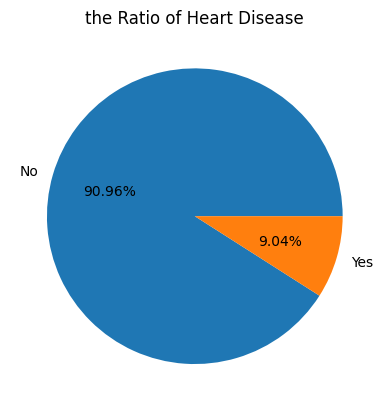

In [ ]:
# 심장병 비율
plt.pie(x=df['HeartDisease'].value_counts(), autopct='%1.2f%%', labels=df['HeartDisease'].value_counts().index)
plt.title("the Ratio of Heart Disease")
plt.show()
# heavily imbalanced data

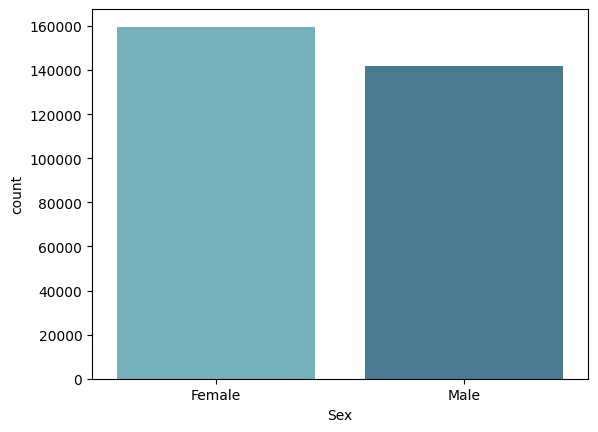

In [ ]:
# 남녀 비율

sns.countplot(x = df['Sex'], palette = 'GnBu_d')
plt.show()

In [ ]:
# 성별에 따른 심장병 발생 빈도
df.groupby(['Sex', 'HeartDisease'])['HeartDisease'].count()

Sex     HeartDisease
Female  No              148458
        Yes              11213
Male    No              125998
        Yes              16048
Name: HeartDisease, dtype: int64

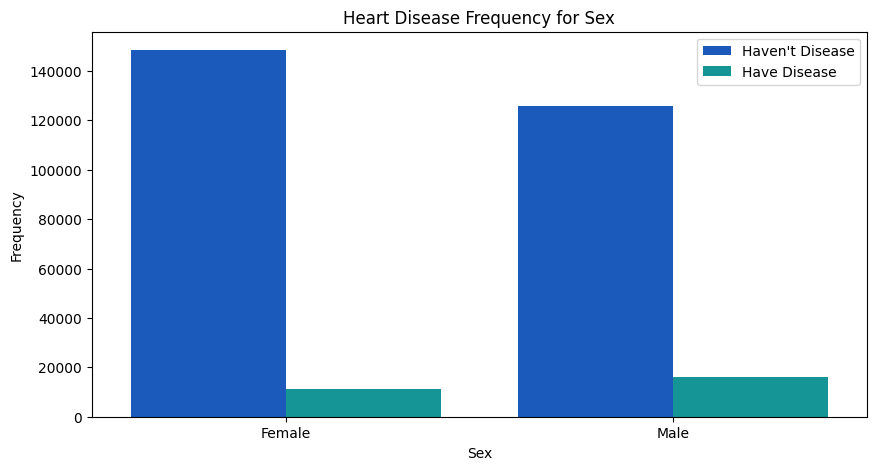

In [ ]:
# 성별에 따른 심장병 발생 빈도 시각화
plt.figure(figsize=(10,5))
sns.countplot(x=df['Sex'], data=df, hue='HeartDisease', palette='winter')
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex')
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
# 연령대 별 비율
df['AgeCategory'].value_counts()

65-69          31670
60-64          31219
70-74          29273
55-59          27610
50-54          23736
80 or older    23352
75-79          20713
45-49          20518
18-24          19998
40-44          19837
35-39          19526
30-34          17953
25-29          16312
Name: AgeCategory, dtype: int64

In [ ]:
# 연령대 별 심장병 발생 빈도
df.groupby(['AgeCategory', 'HeartDisease'])['HeartDisease'].count()

AgeCategory  HeartDisease
18-24        No              19868
             Yes               130
25-29        No              16179
             Yes               133
30-34        No              17727
             Yes               226
35-39        No              19230
             Yes               296
40-44        No              19351
             Yes               486
45-49        No              19775
             Yes               743
50-54        No              22353
             Yes              1383
55-59        No              25411
             Yes              2199
60-64        No              27898
             Yes              3321
65-69        No              27596
             Yes              4074
70-74        No              24456
             Yes              4817
75-79        No              16686
             Yes              4027
80 or older  No              17926
             Yes              5426
Name: HeartDisease, dtype: int64

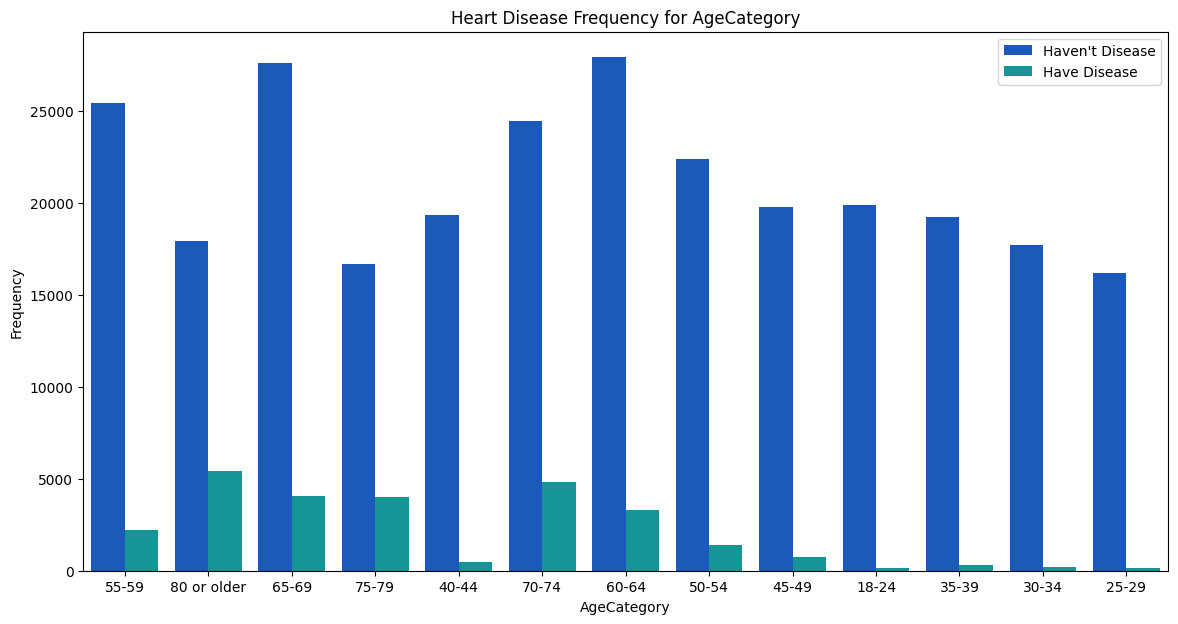

In [ ]:
# 연령대 별 심장병 발생 빈도 시각화
plt.figure(figsize=(14, 7))
sns.countplot(x='AgeCategory', data=df, hue='HeartDisease', palette='winter')
plt.title('Heart Disease Frequency for AgeCategory')
plt.xlabel('AgeCategory')
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
# 흡연 여부
df['Smoking'].value_counts()

No     174312
Yes    127405
Name: Smoking, dtype: int64

In [ ]:
# 성별, 연령대, 흡연여부에 따른 심장병 발생 빈도
df.groupby(['Sex', 'AgeCategory', 'Smoking', 'HeartDisease'])['HeartDisease'].count()

Sex     AgeCategory  Smoking  HeartDisease
Female  18-24        No       No              7963
                              Yes               40
                     Yes      No              1132
                              Yes               10
        25-29        No       No              5746
                                              ... 
Male    75-79        Yes      Yes             1552
        80 or older  No       No              2905
                              Yes             1086
                     Yes      No              3512
                              Yes             1724
Name: HeartDisease, Length: 104, dtype: int64

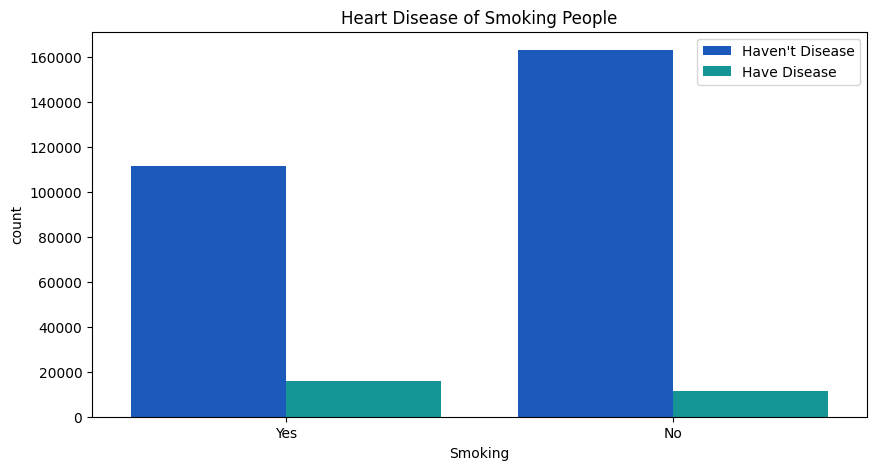

In [ ]:
# 흡연 여부에 따른 심장병 발생 빈도 시각화
plt.figure(figsize=(10,5))
sns.countplot(x='Smoking', data=df, hue='HeartDisease', palette='winter')
plt.title('Heart Disease of Smoking People')
plt.legend(["Haven't Disease", "Have Disease"])
plt.xlabel('Smoking')
plt.show()

In [ ]:
# 음주 여부
df['AlcoholDrinking'].value_counts()

No     280136
Yes     21581
Name: AlcoholDrinking, dtype: int64

In [ ]:
df.groupby(['AlcoholDrinking', 'HeartDisease'])['HeartDisease'].count()

AlcoholDrinking  HeartDisease
No               No              254016
                 Yes              26120
Yes              No               20440
                 Yes               1141
Name: HeartDisease, dtype: int64

In [ ]:
df.groupby(['Sex', 'AgeCategory', 'AlcoholDrinking', 'PhysicalActivity', 'HeartDisease'])['HeartDisease'].count()

Sex     AgeCategory  AlcoholDrinking  PhysicalActivity  HeartDisease
Female  18-24        No               No                No              1419
                                                        Yes                9
                                      Yes               No              6942
                                                        Yes               38
                     Yes              No                No                66
                                                                        ... 
Male    80 or older  No               Yes               Yes             1780
                     Yes              No                No                59
                                                        Yes               34
                                      Yes               No               127
                                                        Yes               41
Name: HeartDisease, Length: 208, dtype: int64

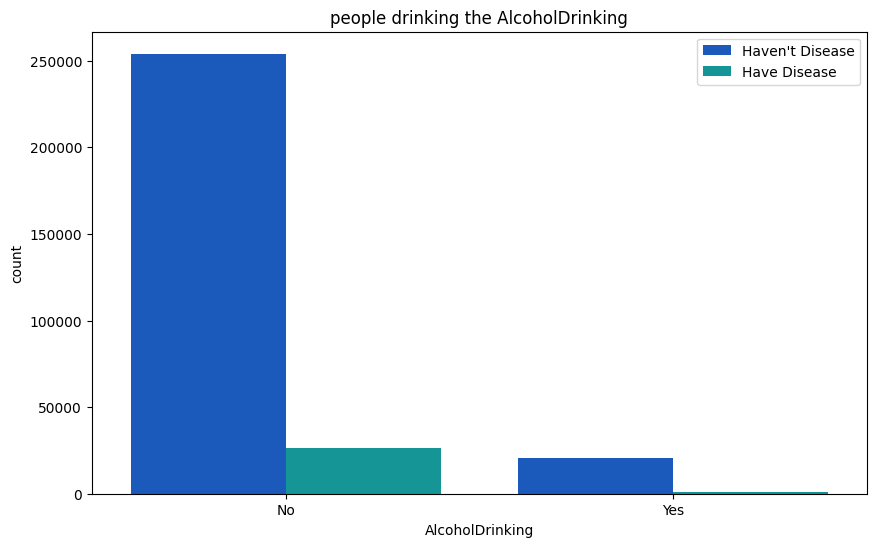

In [ ]:
# 음주 여부에 따른 심장병 발생 빈도 시각화
plt.figure(figsize=(10,6))
sns.countplot(x=df['AlcoholDrinking'], data=df, hue='HeartDisease', palette='winter')
plt.title('people drinking the AlcoholDrinking')
plt.legend(["Haven't Disease", "Have Disease"])
plt.xlabel('AlcoholDrinking')
plt.show()

In [ ]:
# 신장 질환 여부
df['KidneyDisease'].value_counts()

No     289941
Yes     11776
Name: KidneyDisease, dtype: int64

In [ ]:
# 신장 질환에 따른 심장병 여부
df.groupby(['KidneyDisease', 'HeartDisease'])['HeartDisease'].count()

KidneyDisease  HeartDisease
No             No              266134
               Yes              23807
Yes            No                8322
               Yes               3454
Name: HeartDisease, dtype: int64

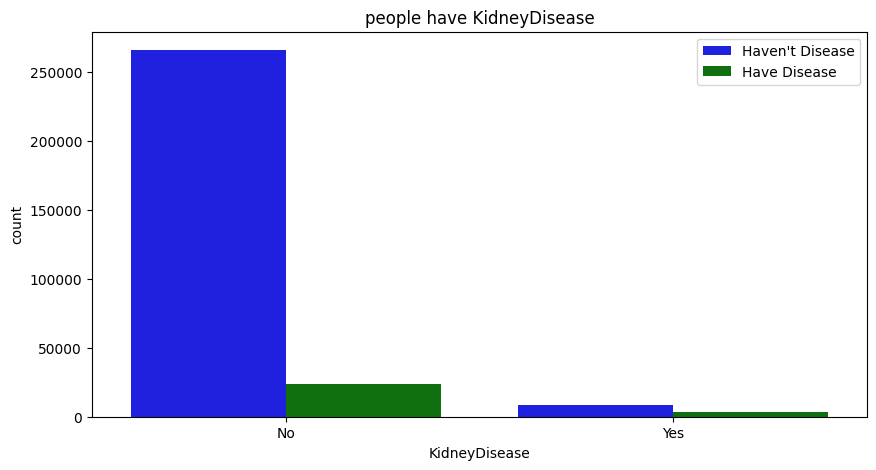

In [ ]:
# 시각화
plt.figure(figsize=(10,5))
sns.countplot(x='KidneyDisease', data=df, hue='HeartDisease', palette=['blue', 'green'])
plt.title('people have KidneyDisease')
plt.legend(["Haven't Disease", "Have Disease"])
plt.xlabel('KidneyDisease')
plt.show()

In [ ]:
df.groupby(['Sex', 'KidneyDisease'])['KidneyDisease'].count()

Sex     KidneyDisease
Female  No               153218
        Yes                6453
Male    No               136723
        Yes                5323
Name: KidneyDisease, dtype: int64

In [ ]:
# 피부암 환자 비율
df['SkinCancer'].value_counts()

No     272425
Yes     29292
Name: SkinCancer, dtype: int64

In [ ]:
df.groupby(['Sex', 'SkinCancer'])['SkinCancer'].count()

Sex     SkinCancer
Female  No            144876
        Yes            14795
Male    No            127549
        Yes            14497
Name: SkinCancer, dtype: int64

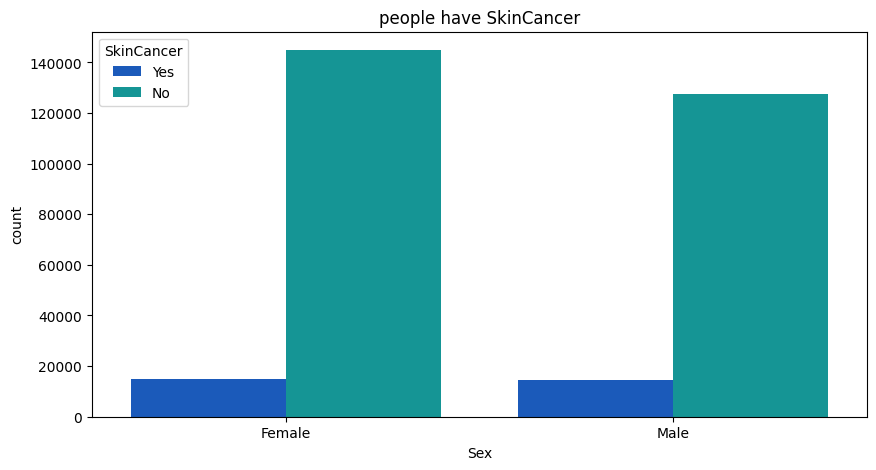

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='Sex', data=df, hue='SkinCancer', palette='winter')
plt.title('people have SkinCancer')
plt.show()

In [ ]:
df.groupby(['Sex', 'SkinCancer', 'HeartDisease'])['HeartDisease'].count()

Sex     SkinCancer  HeartDisease
Female  No          No              135339
                    Yes               9537
        Yes         No               13119
                    Yes               1676
Male    No          No              114793
                    Yes              12756
        Yes         No               11205
                    Yes               3292
Name: HeartDisease, dtype: int64

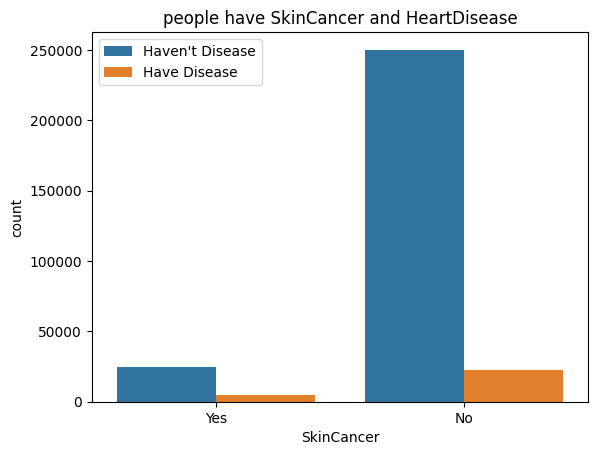

In [ ]:
sns.countplot(x='SkinCancer', data=df, hue='HeartDisease')
plt.title('people have SkinCancer and HeartDisease')
plt.legend(["Haven't Disease", "Have Disease"])
plt.show()

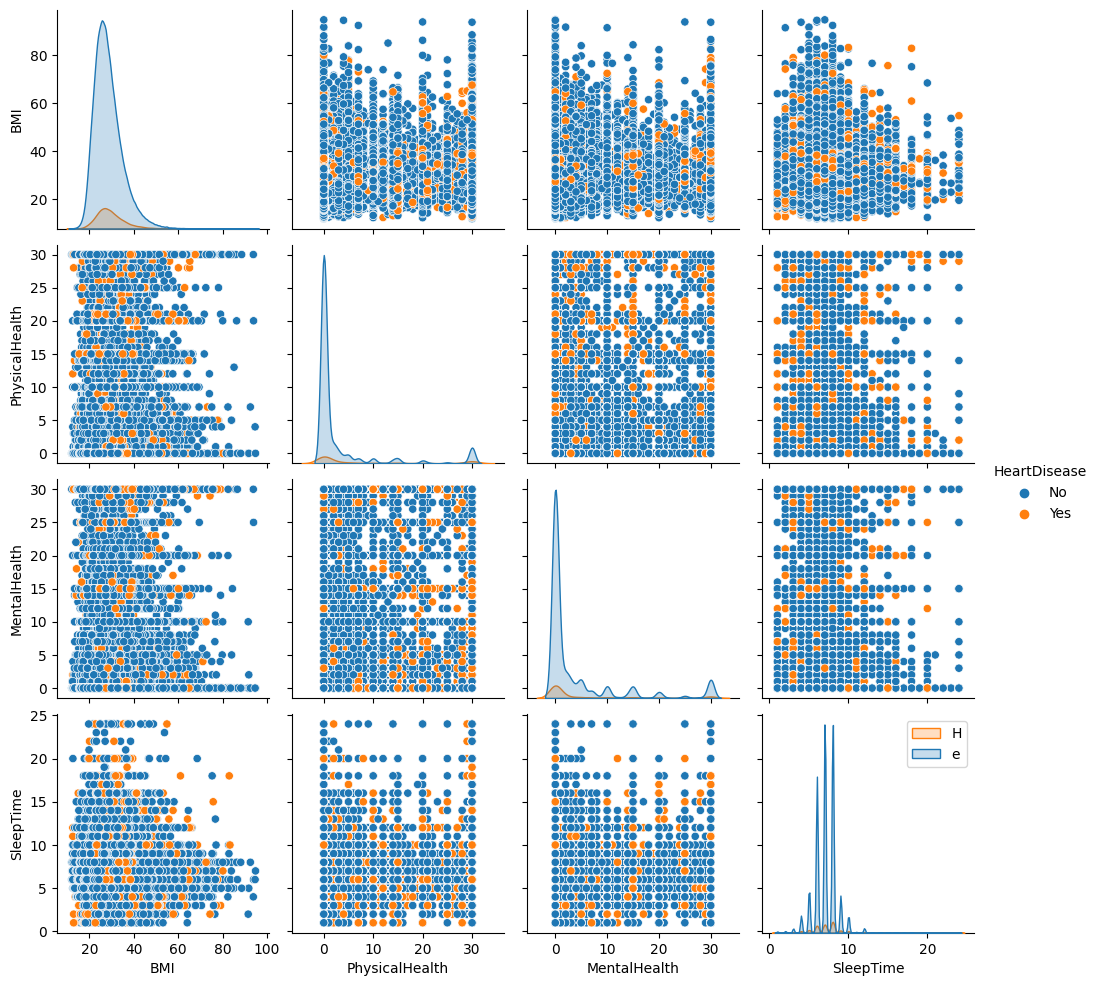

In [ ]:
# 숫자형 피쳐(feature) 분포 및 왜곡도
sns.pairplot(data=df, hue='HeartDisease')
plt.legend('HeartDisease')
plt.show()

## 모델링 ver_1

In [ ]:
# boolean형, 문자형 변수를 라벨인코더를 활용해 변환
label = LabelEncoder()
for col in df:
  df[col] = label.fit_transform(df[col])

df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,223,1,0,0,3,30,0,0,7,5,2,1,4,4,1,0,1
1,0,524,0,0,1,0,0,0,0,12,5,0,1,4,6,0,0,0
2,0,1103,1,0,0,20,30,0,1,9,5,2,1,1,7,1,0,0
3,0,883,0,0,0,0,0,0,0,11,5,0,0,2,5,0,0,1
4,0,837,0,0,0,28,0,1,0,4,5,0,1,4,7,0,0,0


In [ ]:
# 타겟 변수 분리
x = df.drop('HeartDisease', axis= 1)
y = df[['HeartDisease']]

In [ ]:
# 훈련/ 테스트 데이터 분할
from sklearn.model_selection import train_test_split

xtr, xt, ytr, yt = train_test_split(x, y, train_size= 0.7, random_state= 42)

In [ ]:
# 트리 baseline 모델 적합(DecisionTree)
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state= 42)
dt.fit(xtr, ytr)

DecisionTreeClassifier(random_state=42)

In [ ]:
# 오버 샘플링 전, 테스트 데이터에 대한 mean accuracy
dt.score(xt, yt)

0.8538821865747492

In [ ]:
# 오버 샘플링 전, 전체 데이터에 대한 mean accuracy
dt.score(x, y)

0.9544341220415157

## Imbalanced data 조정(오버 샘플링 활용)

In [ ]:
# 오버 샘플링 후 데이터 재할당
over = RandomOverSampler(random_state= 42)
x_new, y_new = over.fit_resample(x, y)

## 모델링 ver_2

In [ ]:
xtr, xt, ytr, yt = train_test_split(x_new, y_new, train_size= 0.7, random_state= 42)

In [ ]:
dt2 = DecisionTreeClassifier(random_state= 42)
dt2.fit(xtr, ytr)

DecisionTreeClassifier(random_state=42)

In [ ]:
# 테스트 데이터 점수(after sampling)
dt2.score(xt, yt)

0.9484739546012121

In [ ]:
# 전체 데이터 점수(after sampling)
dt2.score(xtr, ytr)

0.9979361749748854

## RandomForest

In [ ]:
rf = RandomForestClassifier(random_state= 42)

rf.fit(xtr, ytr)

RandomForestClassifier(random_state=42)

In [ ]:
# 훈련 데이터 정확도 점수 계산
train_score = rf.score(xtr, ytr)
print("Training accuracy:", train_score)

# 테스트 데이터 정확도 점수 계산
test_score = rf.score(xt, yt)
print("Testing accuracy:", test_score)

Training accuracy: 0.9979231622067573
Testing accuracy: 0.9643052333701738


## XGBClassifier

In [ ]:
xgbc = xgb.XGBClassifier(random_state = 42)
xgbc.fit(xtr, ytr)

# 훈련 데이터 정확도 점수 계산
train_score = xgbc.score(xtr, ytr)
print("Training accuracy:", train_score)

# 테스트 데이터 정확도 점수 계산
test_score = xgbc.score(xt, yt)
print("Testing accuracy:", test_score)

Training accuracy: 0.7854194535678408
Testing accuracy: 0.779206189198052


## K-Fold 교차 검증

In [ ]:
kfold = KFold(n_splits= 5, shuffle= True)
# 각각의 fold = 20%

In [ ]:
# 랜덤 포레스트에 적용, 교차 검증 점수 확인
result= cross_val_score(rf, x_new, y_new, cv= kfold)

In [ ]:
result

array([0.96794586, 0.96800051, 0.96864695, 0.96873804, 0.96728972])

In [ ]:
# 평균 점수
result.mean()

0.9681242171824763

In [ ]:
# 최대 점수
result.max()

0.9687380444881675

In [ ]:
# 최소 점수
result.min()

0.9672897196261683

## PCA를 활용한 차원 축소/ 데이터 재분할

In [ ]:
# MinMaxScaler 활용
mmx = MinMaxScaler()

scaled_x = mmx.fit_transform(x_new)
scaled_x.shape

(548912, 17)

In [ ]:
scaled_x

array([[0.06189287, 1.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.14543436, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.30613378, 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.18262559, 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.19816819, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.3719123 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
pca= PCA(n_components= 3)
x_pca= pca.fit_transform(scaled_x)

In [ ]:
x_pca

array([[ 0.24451088,  0.14150583, -0.79696866],
       [-0.43079289,  0.57807423, -0.08602921],
       [ 0.3548885 , -0.54715564, -0.18622559],
       ...,
       [-0.16502868,  0.01294915, -0.88237297],
       [-0.08606101, -0.84403742, -0.11291403],
       [-0.69419621, -0.19410174,  0.42682885]])

In [ ]:
features = pd.DataFrame(x_pca, columns = ['pca1', 'pca2', 'pca3'])

In [ ]:
# 오버 샘플링/ PCA 적용한 데이터 재분할
xtr, xt, ytr, yt = train_test_split(features, y_new, train_size= 0.7, random_state= 42)
xtr

,pca1,pca2,pca3
78195,-0.649394,0.630139,-0.154877
17062,-0.574060,0.616429,-0.153568
158180,-0.664635,0.648626,-0.145538
333159,-0.189672,-0.754412,-0.204117
357122,-0.319697,-0.721859,-0.270033
...,...,...,...
110268,-0.693352,-0.194353,0.433121
259178,0.488489,0.354275,-0.657059
365838,1.238277,-0.490041,0.427823
131932,0.817331,0.990776,0.347437


## LogisticRegression

In [ ]:
lg = LogisticRegression()
lg.fit(xtr, ytr)

# 테스트 데이터 정확도 점수 계산
testing_score = lg.score(xt, yt)
print("Testing accuracy:", testing_score)

# 훈련 데이터 정확도 점수 계산
training_score = lg.score(xtr, ytr)
print("Training accuracy:", training_score)

Testing accuracy: 0.6819655804802215
Training accuracy: 0.6820017801466799


## Linear SGDClassifier

In [ ]:
lsgd = SGDClassifier()
lsgd.fit(xtr, ytr)

# 테스트 데이터 정확도 점수 계산
testing_score = lsgd.score(xt, yt)
print("Testing accuracy:", testing_score)

# 훈련 데이터 정확도 점수 계산
training_score = lsgd.score(xtr, ytr)
print("Training accuracy:", training_score)

Testing accuracy: 0.6569646695896134
Training accuracy: 0.6577720058921814


## DecisionTreeClassifier_3

In [ ]:
dt3 = DecisionTreeClassifier(random_state= 42)
dt3.fit(xtr, ytr)

# 테스트 데이터 정확도 점수 계산
testing_score = dt3.score(xt, yt)
print("Testing accuracy:", testing_score)

# 훈련 데이터 정확도 점수 계산
training_score = dt3.score(xtr, ytr)
print("Training accuracy:", training_score)

Testing accuracy: 0.9480549449214812
Training accuracy: 0.9979361749748854


## KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors= 100)

knn.fit(xtr, ytr)

# 테스트 데이터 정확도 점수 계산
testing_score = knn.score(xt, yt)
print("Testing accuracy:", testing_score)

# 훈련 데이터 정확도 점수 계산
training_score = knn.score(xtr, ytr)
print("Training accuracy:", training_score)

Testing accuracy: 0.7491103635060786
Training accuracy: 0.7539337598051208


## RandomForestClassifier_2

In [ ]:
rf2 = RandomForestClassifier()
rf2.fit(xtr, ytr)

# 테스트 데이터 정확도 점수 계산
testing_score = rf2.score(xt, yt)
print("Testing accuracy:", testing_score)

# 훈련 데이터 정확도 점수 계산
training_score = rf2.score(xtr, ytr)
print("Training accuracy:", training_score)

Testing accuracy: 0.9603458955269198
Training accuracy: 0.9979361749748854


## XGBClassifier_2

In [ ]:
xgbc2 = xgb.XGBClassifier()
xgbc2.fit(xtr, ytr)

# 훈련 데이터 정확도 점수 계산
train_score = xgbc2.score(xtr, ytr)
print("Training accuracy:", train_score)

# 테스트 데이터 정확도 점수 계산
test_score = xgbc2.score(xt, yt)
print("Testing accuracy:", test_score)

Training accuracy: 0.7638729121013539
Testing accuracy: 0.757405540643939


## XGBRFClassifier

In [ ]:
xgbrf = xgb.XGBRFClassifier()
xgbrf.fit(xtr, ytr)

# 테스트 데이터 정확도 점수 계산
testing_score = xgbrf.score(xt, yt)
print("Testing accuracy:", testing_score)

# 훈련 데이터 정확도 점수 계산
training_score = xgbrf.score(xtr, ytr)
print("Training accuracy:", training_score)

Testing accuracy: 0.7277287246316966
Training accuracy: 0.7294723582779423


## ExtraTreesClassifier

In [ ]:
extr = ExtraTreesClassifier()
extr.fit(xtr, ytr)

# 테스트 데이터 정확도 점수 계산
testing_score = extr.score(xt, yt)
print("Testing accuracy:", testing_score)

# 훈련 데이터 정확도 점수 계산
training_score = extr.score(xtr, ytr)
print("Training accuracy:", training_score)

Testing accuracy: 0.9757460194080425
Training accuracy: 0.9979361749748854


## 최종 모델링(VotingClassifier, Final version)

In [ ]:
# 각각의 모델 정의
md1 = DecisionTreeClassifier(random_state= 42)
md2 = RandomForestClassifier(random_state= 42)
md3 = xgb.XGBRFClassifier(random_state= 42)
md4 = ExtraTreesClassifier(random_state= 42)

# VotingClassifier ensemble
ensemble = VotingClassifier(
    estimators = [('dt', md1), ('rf', md2), ('xgb', md3), ('extra', md4)],\
    voting= 'hard' # 다수결 방식
)

# 훈련 데이터 적합
ensemble.fit(xtr, ytr)

# 테스트 데이터 예측
pred = ensemble.predict(xt)
print("y_prediction:", pred)
print()
# 앙상블 모델 성능 측정
acc = accuracy_score(yt, pred)
print("VotingClassifier(Final Model) Accuracy:", round(acc, 4),"%")
print()
print(classification_report(yt, pred))
print()
print(confusion_matrix(yt, pred))

y_prediction: [1 1 0 ... 1 1 0]

VotingClassifier(Final Model) Accuracy: 0.9707 %

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     82143
           1       0.95      1.00      0.97     82531

    accuracy                           0.97    164674
   macro avg       0.97      0.97      0.97    164674
weighted avg       0.97      0.97      0.97    164674


[[77399  4744]
 [   77 82454]]
